# Model situation 1
## Goal:

We want to model a simple market with one normal, one conservative and on risk taking bank, which have different scoring functions and score dependent interest rates. Our aim is to observe the mean score change of borrowers in multiple time steps depending on the institution they choose to borrow from. The decision is based on the borrowers utility, combined with selection rate set by banks based on their utility under different policies.


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo
import support_functions as sf

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


# Variables

In [2]:
time_steps = 1

#Market setting
score_range = [300,850]
repay_score = 75
default_score = -150

#policy
selected_policy = 1  #0=MU, 1=DP , 2=EO 
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

#Bank setting
#use unique names
bank_names = ["reference", "conservative", "risk taking"]
bank_line_style = ['-.','--', ':']
bank_color = ['red', 'blue', 'green']

#score distribution shift
score_shifts = [0, -20, 40]

#bank interest rate setting
interest_range_reference_bank = [0.24, 0.06]
interest_range_conservative_bank = [0.27, 0.04]
interest_range_risk_bank = [0.21, 0.08]
interest_change_up = 0.001
interest_change_down = -0.0005
bank_interest_rate_ranges = [interest_range_conservative_bank, interest_range_risk_bank]

# profit and impact
utility_repaid = 1
utility_default = -4

#Customer groups setting
#use unique names
group_names = ["White","Black"]
group_colors = ['grey', 'black']
group_line_style = ['-',':']


#estimated number of customers in each group
white_totals = 8800
black_totals = 1200
loan_demand = 0.1
interest_rate_limit = 0.15

error_rate = 0.1
score_error = 150

# Objects

In [3]:
class Market:
    def __init__(self, policy, policy_color, score_range = [300,850],repay_score = 75, default_score = -150):
        self.score_range = score_range
        self.policy = policy
        self.policy_color = policy_color
        self.repay_score = repay_score
        self.default_score = default_score
        self.step = 0
        
    def get_selection_rate(self, banks, groups):
        if self.policy == "Max. utility":
            return self.get_MU_selection_rate(banks, groups)
        elif self.policy == "Dem. parity":
            return self.get_DP_selection_rate(banks, groups)
        elif self.policy == "Equal opportunity":
            return self.get_EO_selection_rate(banks, groups)
        else:
            return None
        
    def get_MU_selection_rate(self, banks, groups):
        #Get expected bank utility and set the bank selection rate
        selection_rates = {}
        for bank in banks:
            selection_rates[bank.name] = {}
            utility_curve = {}
            for group in groups:
                utility = 0
                utility_curve[group.name] = []
                for k in range(0, group.size):
                    customer_score = bank.get_expected_customer_score(self, group.scores[k])
                    utility += bank.get_customer_evaluation_utility(customer_score, group)
                    utility_curve[group.name].append(utility)
                bank.set_expected_group_utility_curve(group, utility_curve[group.name])
                #bank.plot_expected_group_utility_curve(group)

                selection_rates[bank.name][group.name] = (len(utility_curve[group.name]) - np.argmax(list(reversed(utility_curve[group.name])))-1)/group.size
                print('Selection rate of ' + bank.name + ' bank for ' + group.name + ' group: ' + str(selection_rates[bank.name][group.name]))
        
        return selection_rates
    
    
    def get_DP_selection_rate(self, banks, groups):
        #Get expected bank utility and set the bank selection rate
        selection_rates = {}
        group_sizes = []
        for bank in banks:
            selection_rates[bank.name] = {}
            utility_curve = {}
            for group in groups:
                utility = 0
                utility_curve[group.name] = []
                group_sizes.append(group.size)
                for k in range(0, group.size):
                    customer_score = bank.get_expected_customer_score(self, group.scores[k])
                    utility += bank.get_customer_evaluation_utility(customer_score, group)
                    utility_curve[group.name].append(utility)
                
            merged_utility_curve = []
            for group in groups:
                if group.size is not max(group_sizes):             
                    x = list(range(0, group.size))
                    x = np.array(x)*(max(group_sizes)/group.size)
                    y = utility_curve[group.name]
                    z = np.polyfit(x, y, 3)
                    p = np.poly1d(z)
                    merged_utility_curve += p(list(range(0,max(group_sizes))))
                else:
                    merged_utility_curve += utility_curve[group.name]
            
            for group in groups:
                bank.set_expected_group_utility_curve(group, merged_utility_curve)
                #bank.plot_expected_group_utility_curve(group)
                selection_rates[bank.name][group.name] = (len(merged_utility_curve) - np.argmax(list(reversed(merged_utility_curve)))-1)/max(group_sizes)
                print('Selection rate of ' + bank.name + ' bank for ' + group.name + ' group: ' + str(selection_rates[bank.name][group.name]))

        return selection_rates
    
    
    def get_EO_selection_rate(self, banks, groups):
        #Get expected bank utility and set the bank selection rate
        selection_rates = {}
        group_sizes = []
        for bank in banks:
            selection_rates[bank.name] = {}
            utility_curve = {}
            TPRs = {}
            for group in groups:
                utility = 0
                utility_curve[group.name] = []
                TPR = 0
                TPRs[group.name] = []
                group_sizes.append(group.size)
                
                for k in range(0, group.size):
                    customer_score = bank.get_expected_customer_score(self, group.scores[k])
                    utility += bank.get_customer_evaluation_utility(customer_score, group)
                    utility_curve[group.name].append(utility)
                    TPR = group.score_repay_prob[customer_score]
                    TPRs[group.name].append(TPR)
            
            #add TPR utility curves together
            main_group_name = groups[group_sizes.index(max(group_sizes))].name
            merged_TPR_utility_curve = utility_curve[main_group_name]
            for group in groups:
                if group.name is not main_group_name:
                    addition=0
                    pos=0
                    for k in range(len(merged_TPR_utility_curve)-1):
                        if TPRs[group.name][pos] <= TPRs[main_group_name][k] and TPRs[group.name][pos] >= TPRs[main_group_name][k+1]:
                            addition = utility_curve[group.name][pos]
                            pos += 1
                            if pos >= group.size:
                                merged_TPR_utility_curve[k] += addition
                                break
                        merged_TPR_utility_curve[k] += addition
                        
                bank.set_expected_group_utility_curve(group, utility_curve[group.name])
            
            #get TPR for max util
            selected_TPR = TPRs[main_group_name][(len(merged_TPR_utility_curve) - np.argmax(list(reversed(merged_TPR_utility_curve)))-1)]
            print('Selected minimal TPR for ' + bank.name + ' bank is: ' + str(selected_TPR))
  
            #get selection rate
            for group in groups:
            
                    for k in range(group.size-1):
                        if TPRs[group.name][k+1] <= selected_TPR and TPRs[group.name][k] >= selected_TPR:
                            selection_rates[bank.name][group.name] = (k+1)/group.size
                            print('Selection rate of ' + bank.name + ' bank for ' + group.name + ' group: ' + str(selection_rates[bank.name][group.name]))
                            break

        return selection_rates
        
    
    def plot_bank_interest_rates(self, banks):
        plt.figure(0)
        x_axis = self.score_range
        for bank in banks:
            y_axis = bank.interest_rate_range
            plt.plot(x_axis, y_axis ,color=bank.color ,LineStyle= bank.line_style, label= bank.name + " bank interest rates")
        plt.ylabel('Interest rate')
        plt.xlabel('Score')
        plt.title('Dependence of interest rate on score for different banks')
        plt.grid('on')
        plt.legend(loc="lower left")
        plt.show()
        return 1
    
    
    def plot_bank_utility_curves(self, banks, groups):
        fig, ax = plt.subplots(len(banks), len(groups),figsize=(16,8*len(banks))); 
        for i in range(len(banks)):
            for j in range(len(groups)):
                ax[i,j].plot(list(range(0,len(banks[i].real_group_utility_curve[groups[j].name]))), banks[i].real_group_utility_curve[groups[j].name], color='black',LineStyle=':', label="Bank utility curve")
                ax[i,j].set_title('Utility curve of ' + str(banks[i].name) + ' bank for ' + str(groups[j].name) + ' group')
                ax[i,j].set_xlabel('Customers')
                ax[i,j].set_ylabel('Bank utility')
                ax[i,j].legend(loc="upper left")
                ax[i,j].grid()
        return 1
    
    def plot_market_situation(self, banks, groups, mean_group_score_curve):
        fig, ax = plt.subplots(3,len(groups),figsize=(16,24))
        
        for i in range(len(groups)):
            ax[0][i].hist(groups[i].scores, range = self.score_range, label='Step ' + str(self.step))
            ax[0][i].set_title(groups[i].name + " group histogram change for " + self.policy + " policy")
            ax[0][i].set_ylabel("Occurence")
            ax[0][i].set_xlabel("Score")
            ax[0][i].set_ylim([0,groups[i].size*0.75])
            ax[0][i].legend(loc="upper left")
            
            y_axis = mean_group_score_curve[groups[i].name]
            ax[1][1].plot(list(range(len(mean_group_score_curve[groups[i].name]))),y_axis ,color=groups[i].color, label= groups[i].name + " group mean score")
                        
        ax[1][1].set_ylabel('Mean score')
        ax[1][1].set_xlabel('Step')
        ax[1][1].set_title('Mean score of different groups in time step:' + str(self.step))
        ax[1][1].grid()
        ax[1][1].legend(loc="lower left")
        
        
        x_axis = self.score_range
        for bank in banks:
            y_axis = bank.interest_rate_range
            ax[1][0].plot(x_axis, y_axis ,color=bank.color ,LineStyle= bank.line_style, label= bank.name + " bank interest rates")
            
            for group in groups:
                ax[2][0].plot(list(range(len(bank.N_loan_curves[group.name]))), bank.N_loan_curves[group.name], color=bank.color, LineStyle=group.line_style, label= bank.name + " bank: "+ group.name + " group")
                ax[2][1].plot(list(range(len(bank.total_utility_curves[group.name]))), bank.total_utility_curves[group.name], color=bank.color, LineStyle=group.line_style,label= bank.name + " bank: "+ group.name + " group")
            
        ax[1][0].set_ylabel('Interest rate')
        ax[1][0].set_xlabel('Score')
        ax[1][0].set_title('Dependence of interest rate on score for different banks in step:' + str(self.step))
        ax[1][0].grid()
        ax[1][0].legend(loc="lower left")
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[2][0].set_ylabel('Number of loans [log]')
        ax[2][0].set_title('Total number of loans given by bank to a group: step ' + str(self.step))
        ax[2][0].set_yscale('log')
        ax[2][0].grid()
        ax[2][0].legend()
        
        ax[2][1].set_ylabel('Utility [log]')
        ax[2][1].set_title('Total bank utility by group: step ' + str(self.step))
        ax[2][1].set_yscale('log')
        ax[2][1].grid()
        ax[2][1].legend()
        
        #fig.savefig('../plots/MV3step'+ '%03d' % self.step +'.png')
                          
        return 1
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
class Bank:
    def __init__(self, name, color, line_style, interest_rate_range, market, score_shift=0, utility_repaid=1, utility_default= -4):
        self.name = name
        self.color = color
        self.line_style = line_style
        self.interest_rate_range = interest_rate_range
        self.score_shift = score_shift
        self.utility_repaid = utility_repaid
        self.utility_default = utility_default
        self.score_interest_rates = {}
        self.set_i_rates_mapping(market)
        self.expected_group_utility_curve = {}
        self.group_selection_rate = {}
        self.real_group_utility_curve = {}
        self.market_share = {}
        self.N_loan_curves = {}
        self.total_utility_curves = {}
        
    def set_i_rates_mapping(self, market):
        x_axis = np.linspace(market.score_range[0],market.score_range[1],market.score_range[1]-market.score_range[0]+1, dtype=int)
        y_axis = np.interp(x_axis, score_range, self.interest_rate_range)   
        self.score_interest_rates = dict(zip(x_axis, np.around(y_axis,4)))
        return self.score_interest_rates
    
    def get_expected_customer_score(self, market, customer_score):
        expected_customer_score = 0
        if customer_score + self.score_shift < market.score_range[0]:
            expected_customer_score = market.score_range[0]
        elif customer_score + self.score_shift > market.score_range[1]:
            expected_customer_score = market.score_range[1]
        else:
            expected_customer_score = customer_score + self.score_shift
        return expected_customer_score
    
    def get_customer_evaluation_utility(self, expected_customer_score, customer_group):
        return self.utility_default*(1-customer_group.score_repay_prob[expected_customer_score]) + (self.utility_repaid+self.score_interest_rates[expected_customer_score])*customer_group.score_repay_prob[expected_customer_score]
    
    def get_customer_utility(self, expected_customer_score, customer_group, outcome):
        utility = 0
        if outcome:
            utility = self.utility_repaid+self.score_interest_rates[expected_customer_score]
        else:
            utility = self.utility_default
        return utility
    
    def set_expected_group_utility_curve(self, customer_group, expected_utility):
        self.expected_group_utility_curve[customer_group.name] = expected_utility
        return self.expected_group_utility_curve[customer_group.name]
    
    def change_interest_rate(self, interest_change, market):
        if self.interest_rate_range[1] + interest_change >= 0:
            self.interest_rate_range[0] += interest_change
            self.interest_rate_range[1] += interest_change
            self.set_i_rates_mapping(market)
        return self.interest_rate_range
    
    def plot_expected_group_utility_curve(self, customer_group):
        plt.plot(list(range(0, len(self.expected_group_utility_curve[customer_group.name]))), self.expected_group_utility_curve[customer_group.name], color='black',LineStyle=':', label="expected bank utility curve")
        plt.ylabel('Utility')
        plt.xlabel('Customers')
        plt.title('Expected utility curve of ' + self.name + ' bank for ' + customer_group.name + ' group')
        plt.grid('on')
        plt.legend(loc="lower left")
        #plt.show()
        return 1
    
    def set_selection_rate(self, selection_rates):
        for group_name, selection_rate in selection_rates.items():
            self.group_selection_rate[group_name] = selection_rate     
        return 1
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
class Customer_group:
    def __init__(self, name, color, line_style, size, scores, loan_demand, error_rate, score_error, market, repays, interest_rate_limit):
        self.name = name
        self.color = color
        self.line_style = line_style
        self.size = size
        self.scores = scores
        self.real_scores = self.set_real_scores(error_rate, score_error)
        self.sort_scores()
        self.loan_demand = loan_demand
        self.score_repay_prob = self.get_repay_prob_mapping(market.score_range, repays)
        self.interest_rate_limit = interest_rate_limit
        
    def get_repay_prob_mapping(self, score_range, repay_prob):
        x_axis = np.linspace(score_range[0],score_range[1],score_range[1]-score_range[0]+1, dtype=int)
        y_axis = np.interp(x_axis, repay_prob.index, repay_prob[self.name])
        return dict(zip(x_axis, y_axis))
    
        #get simulated repay outcome of score probability(1=repaid, 0=default )
    def get_repay_outcome(self, repay_probability):
        random_number = random.random()
        outcome = 1
        #print(random_number)
        if random_number < 1-repay_probability:
            outcome = 0
        return outcome
    
        #simulating that some members of the group have better score/repay prob then rated
    def set_real_scores(self, error_rate, score_error):
        real_scores = self.scores.copy()
        better_customers = np.sort(random.sample(range(0, self.size), int(self.size*error_rate)))
        for customer in better_customers:
            if real_scores[customer] + score_error < market.score_range[0]:
                real_scores[customer] = market.score_range[0]
            elif real_scores[customer] + score_error > market.score_range[1]:
                real_scores[customer] = market.score_range[1]
            else:
                real_scores[customer] += score_error
        return real_scores
    
    def get_mean_score(self):
        return np.mean(self.scores)
    
    def sort_scores(self):
        numpy.set_printoptions(threshold=sys.maxsize)
        sorted_indices = np.argsort(self.scores[::-1])
        sorted_scores = np.zeros(len(sorted_indices), dtype = int) 
        sorted_real_scores = np.zeros(len(sorted_indices), dtype = int) 
        for i in range(0, len(sorted_indices)): 
            sorted_scores[::-1][i] = self.scores[::-1][sorted_indices[i]]
            sorted_real_scores[::-1][i] = self.real_scores[::-1][sorted_indices[i]]
        self.scores = sorted_scores
        self.real_scores = sorted_real_scores
        return self.scores
    
    def select_score_change(self, market, outcome):
        if outcome:
            return market.repay_score
        else:
            return market.default_score
    
    def change_score(self, market, customer_index, outcome):
        score_change = self.select_score_change(market, outcome)
        if self.scores[customer_index] + score_change < market.score_range[0]:
            self.scores[customer_index] = market.score_range[0]
        elif self.scores[customer_index] + score_change > market.score_range[1]:
            self.scores[customer_index] = market.score_range[1]
        else:
            self.scores[customer_index] += score_change
        
        return self.scores[customer_index]
    
    def change_real_score(self, market, customer_index, outcome):
        score_change = self.select_score_change(market, outcome)
        if self.real_scores[customer_index] + score_change < market.score_range[0]:
            self.real_scores[customer_index] = market.score_range[0]
        elif self.real_scores[customer_index] + score_change > market.score_range[1]:
            self.real_scores[customer_index] = market.score_range[1]
        else:
            self.real_scores[customer_index] += score_change
        
        return self.real_scores[customer_index]
    
    def plot_histogram(self, market):
        plt.figure()
        plt.hist(self.scores, range = market.score_range, label='Step ' + str(market.step))
        plt.title(self.name + " group histogram change for " + market.policy + " policy")
        plt.ylabel("Occurence")
        plt.xlabel("Score")
        plt.ylim([0,self.size*0.75])
        plt.legend(loc="upper left")
        plt.show()
        return 1
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

# Prepare initial data

In [4]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

# demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customer_scores = sf.get_ref_customers(customer_totals, pis_total, scores_list)

../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


Reference group totals: [8800 1200]
Calculated group totals: [8805 1193]
Group size ratio: [ 0.88067614  0.11932386]


# Create Model

In [5]:
market = Market(policy_names[selected_policy], policy_colors[selected_policy], score_range = score_range ,repay_score = repay_score, default_score = default_score)

reference_bank = Bank(bank_names[0], bank_color[0],bank_line_style[0], interest_range_reference_bank, market, score_shifts[0])
conservative_bank = Bank(bank_names[1], bank_color[1], bank_line_style[1], interest_range_conservative_bank, market, score_shifts[1])
#risk_taking_bank = Bank(bank_names[2], bank_color[2], bank_line_style[2], interest_range_risk_bank, market, score_shifts[2])
banks=[reference_bank, conservative_bank]#, risk_taking_bank]

white_group = Customer_group(group_names[0], group_colors[0], group_line_style[0], customer_totals[0], ref_customer_scores[0], loan_demand, 0, 0, market, repays, interest_rate_limit)
black_group = Customer_group(group_names[1], group_colors[1], group_line_style[1], customer_totals[1], ref_customer_scores[1], loan_demand, error_rate, score_error, market, repays, interest_rate_limit)
groups = [white_group, black_group]

In [6]:
data1 = market.get_MU_selection_rate(banks, groups)
data2 = market.get_DP_selection_rate(banks, groups)
data3 = market.get_EO_selection_rate(banks, groups)

Selection rate of reference bank for White group: 0.675298126065
Selection rate of reference bank for Black group: 0.173512154233
Selection rate of conservative bank for White group: 0.629642248722
Selection rate of conservative bank for Black group: 0.142497904443
Selection rate of reference bank for White group: 0.602498580352
Selection rate of reference bank for Black group: 0.602498580352
Selection rate of conservative bank for White group: 0.546053378762
Selection rate of conservative bank for Black group: 0.546053378762
Selected minimal TPR for reference bank is: 0.782008
Selection rate of reference bank for White group: 0.673708120386
Selection rate of reference bank for Black group: 0.1743503772
Selected minimal TPR for conservative bank is: 0.782008
Selection rate of conservative bank for White group: 0.62793867121
Selection rate of conservative bank for Black group: 0.14333612741


### Init model values

In [7]:
for bank in banks:
    for group in groups:
        bank.N_loan_curves[group.name] = []
        bank.total_utility_curves[group.name] = []

mean_group_score_curve = {}
for group in groups:      
    mean_group_score_curve[group.name] = []

# Next step

Selection rate of reference bank for White group: 0.602498580352
Selection rate of reference bank for Black group: 0.602498580352
Selection rate of conservative bank for White group: 0.546053378762
Selection rate of conservative bank for Black group: 0.546053378762
White group mean score: 654.782169222 at step: 0
Black group mean score: 515.042749371 at step: 0
Market share reference bank: 0.41834191532
[0.2395, 0.0595] interest rate: bank reference
Market share conservative bank: 0.556833496483
[0.2695, 0.0395] interest rate: bank conservative


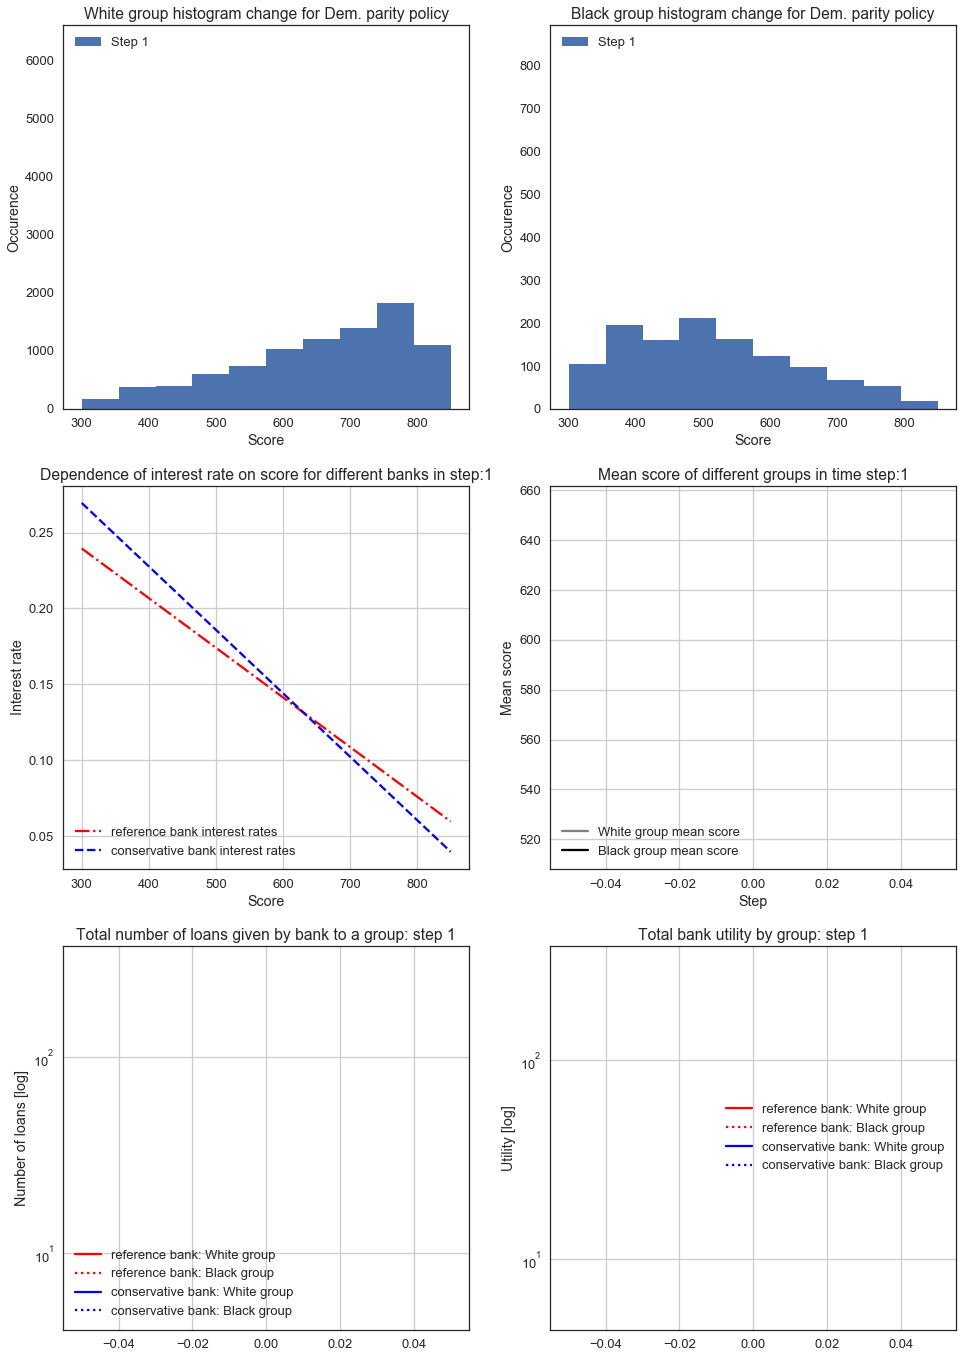

In [8]:
for time in range(0, time_steps):
    utilities = {}
    utility_curves = {}
    N_loans = {}
    
    
    #Before            
    selection_rates = market.get_selection_rate(banks, groups)
    for bank in banks:
        bank.set_selection_rate(selection_rates[bank.name])
        utilities[bank.name] = {}
        utility_curves[bank.name] = {}
        N_loans[bank.name] = {}

    #During
    for group in groups:
        for bank in banks:
            utilities[bank.name][group.name] = 0
            utility_curves[bank.name][group.name] = []
            N_loans[bank.name][group.name] = 0
            
        #select part of customer base according to group loan demand
        customers = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        #go over all selected customers in the group
        for j in customers:
            best_bank = None
            best_interest_rate = np.Infinity
            
            # check which bank gives best interest rate
            for k in range(len(banks)):
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    expected_customer_score = banks[k].get_expected_customer_score(market, group.scores[j])
                    interest_rate = banks[k].score_interest_rates[expected_customer_score]
                    if interest_rate < best_interest_rate and interest_rate < group.interest_rate_limit:
                        best_interest_rate = interest_rate
                        best_bank = k

            #print(best_bank)
            if best_bank is not None:
                #get loan outcome and change score
                N_loans[banks[best_bank].name][group.name] += 1 
                real_customer_score = group.real_scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_customer_score])
                expected_customer_score = banks[best_bank].get_expected_customer_score(market, group.scores[j])
                group.change_score(market, j, loan_outcome)
                group.change_real_score(market, j, loan_outcome)
                
                #get bank utility
                utility_change = banks[best_bank].get_customer_utility(expected_customer_score, group, loan_outcome)
                utilities[banks[best_bank].name][group.name] += utility_change
                utility_curves[banks[best_bank].name][group.name].append(utilities[banks[best_bank].name][group.name])
        for bank in banks:
            if market.step == 0:
                bank.N_loan_curves[group.name].append(N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(utilities[bank.name][group.name])
            else:
                bank.N_loan_curves[group.name].append(bank.N_loan_curves[group.name][-1] + N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(bank.total_utility_curves[group.name][-1] + utilities[bank.name][group.name])        
        group.sort_scores()
        mean_group_score_curve[group.name].append(group.get_mean_score())
        print(group.name + " group mean score: " + str(group.get_mean_score())+ " at step: " + str(market.step))
    
    market.step += 1
    
    
    #After
    #adjust interest rate, we will need market share and utilities for this
    for bank in banks:

        bank_clients = 0
        total_clients = 0
        max_expected_utility = 0
        real_utility = 0
        #calculate market share and utilities
        for group in groups:
            bank.real_group_utility_curve[group.name] = utility_curves[bank.name][group.name]
            total_clients += group.size * group.loan_demand * bank.group_selection_rate[group.name]
            bank_clients += len(bank.real_group_utility_curve[group.name])   
            max_expected_utility += np.max(bank.expected_group_utility_curve[group.name])* group.loan_demand

            if len(bank.real_group_utility_curve[group.name])>0:
                real_utility += bank.real_group_utility_curve[group.name][-1]                                   

        bank.market_share = bank_clients/total_clients 
        print("Market share " + bank.name + " bank: " + str(bank.market_share))
        #change interest rate according to actual market share and utility
        if bank.market_share >= 1/len(banks) and real_utility >= max_expected_utility/len(banks):
            bank.change_interest_rate(interest_change_up, market)
        else:
            bank.change_interest_rate(interest_change_down, market)
        print(str(bank.interest_rate_range) + " interest rate: bank " + bank.name)

    market.plot_market_situation(banks, groups, mean_group_score_curve)

1

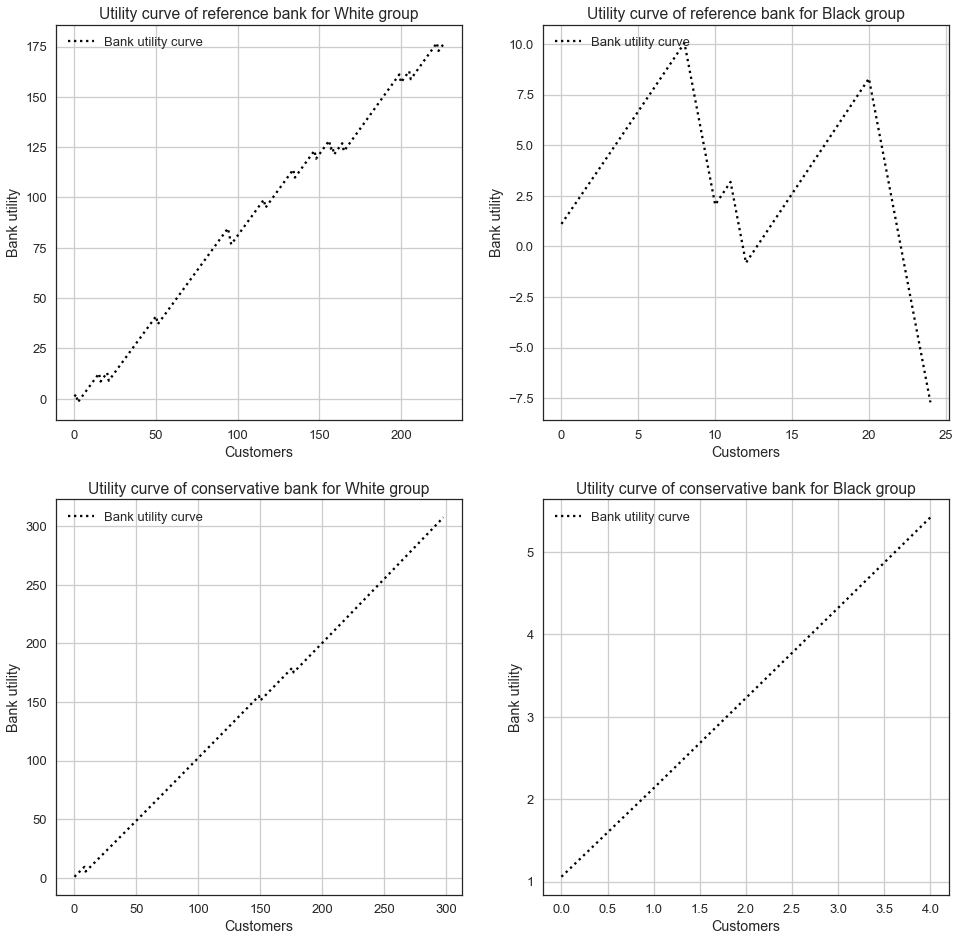

In [9]:
market.plot_bank_utility_curves(banks, groups)